In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import string
# from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
cm_header = list(pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\cm_header_file.csv").columns)
committee_master = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\cm_16.txt",sep = "|" ,names = cm_header)
committee_master.head()

,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID
0,C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,NaN,NaN
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,NaN,M,M,AMERICAN MEDICAL ASSOCIATION,NaN
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,NaN,OKLAHOMA CITY,OK,73107,U,N,NaN,Q,L,TEAMSTERS LOCAL UNION 886,NaN
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,NaN,TOPEKA,KS,66612,U,Q,UNK,Q,T,NaN,NaN
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",NaN,INDIANAPOLIS,IN,46202,U,Q,NaN,Q,M,NaN,NaN


In [3]:
zip_county = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_Project\zip_county_cross.csv")
zip_county['ZIP_CODE'] = zip_county['ZIP_CODE'].astype(str)
zip_county['ZIP_CODE'] = zip_county['ZIP_CODE'].str[:5]
zip_county['ZIP_CODE'] = zip_county['ZIP_CODE'].astype(int)
zip_county.head()

,County,STATE,lookup,STCOUNTYFP,CLASSFP,ZIP_CODE
0,Prince of Wales-Hyder,AK,princeofwaleshyderak,2198,H5,99927
1,Prince of Wales-Hyder,AK,princeofwaleshyderak,2198,H5,99926
2,Prince of Wales-Hyder,AK,princeofwaleshyderak,2198,H5,99919
3,Prince of Wales-Hyder,AK,princeofwaleshyderak,2198,H5,99918
4,Prince of Wales-Hyder,AK,princeofwaleshyderak,2198,H5,99921


In [4]:
zip_county[zip_county['STATE'] == "OR"].head()

,County,STATE,lookup,STCOUNTYFP,CLASSFP,ZIP_CODE
6488,Hood River,OR,hoodriveror,41027,H1,97014
6489,Hood River,OR,hoodriveror,41027,H1,97044
6490,Hood River,OR,hoodriveror,41027,H1,97031
6491,Hood River,OR,hoodriveror,41027,H1,97041
6492,Washington,OR,washingtonor,41067,H1,97078


In [5]:
cont_columns = list(pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\indiv_header_file.csv").columns)

In [6]:
test = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\itcont_2016.txt",sep = "|" ,names = cont_columns, nrows=250000)

C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# chunkappend = pd.DataFrame()
# for chunk in pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\itcont_2016.txt",sep = "|" ,names = cont_columns, chunksize=10000):
#     chunk = pd.merge(chunk,committee_master, on = ['CMTE_ID'], how = 'inner')
#     chunk['ZIP_CODE'] = chunk['ZIP_CODE'].astype(str)
#     chunk['ZIP_CODE'] = chunk['ZIP_CODE'].str[:5]
#     chunk['ZIP_CODE'] = np.where(chunk['ZIP_CODE'].isna(),0,chunk['ZIP_CODE'])
#     chunk['ZIP_CODE'] = chunk['ZIP_CODE'].apply(lambda x: "".join([l for l in str(x) if l.isdigit()]) if x is not None else "")
#     chunk['ZIP_CODE'] = np.where(chunk['ZIP_CODE'] == "",0,chunk['ZIP_CODE'])
#     chunk['ZIP_CODE'] = chunk['ZIP_CODE'].astype(int)
#     chunk = pd.merge(chunk, zip_county, on = "ZIP_CODE")
#     temp = chunk.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','CAND_ID'])['TRANSACTION_AMT'].agg(['sum','count']).reset_index()

#     chunkappend = chunkappend.append(temp)
# chunkappend.head()

In [8]:
chunkappend = pd.DataFrame()
for chunk in pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\itcont_2016.txt",sep = "|" ,names = cont_columns, chunksize=250000):
    chunk = pd.merge(chunk,committee_master, on = ['CMTE_ID'], how = 'inner')
    chunk['ZIP_CODE'] = chunk['ZIP_CODE'].astype(str)
    chunk['ZIP_CODE'] = chunk['ZIP_CODE'].str[:5]
    chunk['ZIP_CODE'] = np.where(chunk['ZIP_CODE'].isna(),0,chunk['ZIP_CODE'])
    chunk['ZIP_CODE'] = chunk['ZIP_CODE'].apply(lambda x: "".join([l for l in str(x) if l.isdigit()]) if x is not None else "")
    chunk['ZIP_CODE'] = np.where(chunk['ZIP_CODE'] == "",0,chunk['ZIP_CODE'])
    chunk['ZIP_CODE'] = chunk['ZIP_CODE'].astype(int)
    chunk = pd.merge(chunk, zip_county, on = "ZIP_CODE")
    temp = chunk.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','CAND_ID'])['TRANSACTION_AMT'].agg(['sum','count']).reset_index()
    chunkappend = chunkappend.append(temp)
chunkappend.head()

C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=resu

,STCOUNTYFP,CMTE_PTY_AFFILIATION,CAND_ID,sum,count
0,1001.0,REP,P60005915,500,1
1,1003.0,DEM,H0AL07086,5200,2
2,1003.0,DEM,H0WA02080,1000,1
3,1003.0,DEM,S6FL00319,2700,1
4,1003.0,REP,H2UT01094,2700,1


In [9]:
# dateappend = pd.DataFrame()
# for test in pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\itcont_2016.txt",sep = "|" ,names = cont_columns, chunksize=250000):
#     test['TRANSACTION_DT'] = test['TRANSACTION_DT'].astype(str)
#     test['TRANSACTION_DT'] = np.where(test['TRANSACTION_DT'].str.len() == 7, '0' + test['TRANSACTION_DT'], test['TRANSACTION_DT'])
#     test['TRANSACTION_DT'] = pd.to_datetime(test['TRANSACTION_DT'], format = '%m%d%Y', errors = 'coerce')
#     test['election_day'] = pd.to_datetime('11082016', format = '%m%d%Y', errors = 'ignore')
#     test['days_until_election'] = test['election_day'] - test['TRANSACTION_DT']
#     test['days_until_election'] = test['days_until_election'].dt.days
#     test['ZIP_CODE'] = test['ZIP_CODE'].astype(str)
#     test['ZIP_CODE'] = test['ZIP_CODE'].str[:5]
#     test['ZIP_CODE'] = np.where(test['ZIP_CODE'].isna(),0,test['ZIP_CODE'])
#     test['ZIP_CODE'] = test['ZIP_CODE'].apply(lambda x: "".join([l for l in str(x) if l.isdigit()]) if x is not None else "")
#     test['ZIP_CODE'] = np.where(test['ZIP_CODE'] == "",0,test['ZIP_CODE'])
#     test['ZIP_CODE'] = test['ZIP_CODE'].astype(int)
#     test = pd.merge(test,committee_master, on = 'CMTE_ID', how = 'inner')
#     test = pd.merge(test, zip_county, on = "ZIP_CODE")
#     test = test.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','days_until_election'])['TRANSACTION_AMT'].agg(['sum','count']).reset_index()
#     dateappend = dateappend.append(test)
    
# dateappend['date_donation_amt'] = dateappend.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','days_until_election'])['sum'].transform(sum)
# dateappend['date_donation_cnt'] = dateappend.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','days_until_election'])['count'].transform(sum)
# dateappend.drop_duplicates(['STCOUNTYFP','CMTE_PTY_AFFILIATION','days_until_election'], inplace = True)
# dateappend.rename(columns={"STCOUNTYFP":'county_fips','CMTE_PTY_AFFILIATION':'party'}, inplace = True)
# dateappend.drop(['sum','count'],axis=1,inplace = True)
# dateappend['county_fips'] = dateappend['county_fips'].astype(int)
# dateappend['day_cut'] = pd.cut(dateappend['days_until_election'].astype(int), [x for x in range(0,dateappend['days_until_election'].astype(int).max()) if x%50 == 0])
# dateappend['cut_donations'] = dateappend.groupby(['county_fips','party','day_cut'])['date_donation_amt'].transform(sum)
# dateappend['cut_count'] = dateappend.groupby(['county_fips','party','day_cut'])['date_donation_cnt'].transform(sum)
# dateappend.drop_duplicates(['county_fips','party','day_cut'], inplace = True)

# dateappend = dateappend[(dateappend['party'] == 'REP')  | (dateappend['party'] == 'DEM')]
# dateappend.to_csv(r'C:\Users\krred\Documents\Berkeley\w209\Final_Project\date_donations.csv')
# dateappend.head()

In [10]:
transfer = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_Project\itpas2.txt",sep = "|", names = list(pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_Project\pas2_header_file.csv").columns))
transfer = pd.merge(transfer,committee_master, on = ['CMTE_ID'], how = 'inner', suffixes = ("","y"))
transfer[~transfer['CAND_ID'].isna()]
transfer = pd.merge(transfer, zip_county, on = "ZIP_CODE")
transfer = transfer.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','CAND_ID'])['TRANSACTION_AMT'].agg(['sum','count']).reset_index()
donations = chunkappend.append(transfer)

donations['STCOUNTYFP'] = donations['STCOUNTYFP'].astype(int)
donations['total_donations'] = donations.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','CAND_ID'])['sum'].transform(sum)
donations['donation_count'] = donations.groupby(['STCOUNTYFP','CMTE_PTY_AFFILIATION','CAND_ID'])['count'].transform(sum)
donations.drop_duplicates(['STCOUNTYFP','CMTE_PTY_AFFILIATION','CAND_ID'], inplace = True)
donations.rename(columns = {'STCOUNTYFP':"county_fips", "CAND_ID":"candidate_fec"}, inplace = True)
donations.drop(['sum','count'],axis = 1, inplace=True)
donations = donations[(donations['CMTE_PTY_AFFILIATION'] == 'DEM') | (donations['CMTE_PTY_AFFILIATION'] == 'REP')]
donations.to_csv(r'C:\Users\krred\Documents\Berkeley\w209\Final_Project\donate_by_fips.csv')
donations.head()

C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,11,12,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,county_fips,CMTE_PTY_AFFILIATION,candidate_fec,total_donations,donation_count
0,1001,REP,P60005915,21157,65
1,1003,DEM,H0AL07086,11000,5
2,1003,DEM,H0WA02080,2000,2
3,1003,DEM,S6FL00319,10185,45
4,1003,REP,H2UT01094,2700,1


In [11]:
check = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\2016-precinct-president.csv", encoding='latin1')

C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (13,17,19,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
votes = pd.DataFrame()
for level in ['house','president','senate']:
    temp = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\2016-precinct-{}.csv".format(level), encoding='latin1')
#     temp = temp[~temp['party'].isna()]
    temp['candidate_fec'] = np.where(temp['candidate_fec'].isna(),"",temp['candidate_fec'])
    if 'candidate_party' in temp.columns:
        print(level)
        temp['party_test'] = temp['party'].str.split(',', expand = True)[0]
        temp['party'] = np.where(temp['party'].str.contains(","),temp['party_test'],temp['party'])
        temp['candidate_party'] = temp['candidate_party'].astype(str)
        temp['candidate_party'] = temp['candidate_party'].str.lower()
        temp['candidate_party'] = np.where(temp['candidate_party'].str.lower().str.strip() == 'democrat','democratic',temp['candidate_party'])
        temp['party'] = np.where(temp['party'].str.lower() == "dem", 'democratic', temp['party'])
        temp['party'] = np.where(temp['party'].str.lower() == "rep", 'republican', temp['party'])

        temp['party'] = np.where((temp['party'].isna()) | (temp['party'].str.strip() == ""), temp['candidate_party'], temp['party'])
        temp['party'] = np.where(temp['party'].str.lower() == 'democratic-farmer-labor', 'democratic', temp['party'])
        temp['party'] = np.where(temp['candidate'].str.strip().str.lower() == 'hillary clinton','democratic', temp['party'])
        temp['party'] = np.where(temp['candidate'].str.strip().str.lower() == 'donald trump','democratic', temp['party'])
        temp['candidate_fec'] = np.where(temp['candidate_fec'].isna(),"",temp['candidate_fec'])
    temp = temp.groupby(['state_postal','county_fips','county_name','candidate','candidate_fec','party','office'])['votes'].sum().reset_index()
    temp['party'] = temp['party'].astype(str)
    temp['office'] = temp['office'].astype(str)
    
    temp = temp[(temp['party']== 'republican') | (temp['party']== 'democratic') | (temp['party']== 'democrat')]
    temp = temp[~(temp['office']== 'Straight Party')]
    votes = votes.append(temp)
votes = votes[~votes['county_fips'].isna()]
votes['party'] = np.where(votes['party']=='republican',"REP","DEM")
votes['county_fips'] = votes['county_fips'].astype(int)
votes.head()

C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


house


C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (13,17,19,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


president


C:\Users\krred\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (13,19,27,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


senate


,state_postal,county_fips,county_name,candidate,candidate_fec,party,office,votes
2,AL,1001,Autauga County,Martha Roby,H0AL02087,REP,US House,14315
3,AL,1001,Autauga County,Nathan Mathis,H6AL02167,DEM,US House,7544
7,AL,1003,Baldwin County,Bradley Byrne,H4AL01123,REP,US House,76995
11,AL,1005,Barbour County,Martha Roby,H0AL02087,REP,US House,4286
12,AL,1005,Barbour County,Nathan Mathis,H6AL02167,DEM,US House,5297


In [13]:
votes[votes['state_postal'] == '']

,state_postal,county_fips,county_name,candidate,candidate_fec,party,office,votes


In [14]:
county_donations_tot = donations.groupby(['county_fips','CMTE_PTY_AFFILIATION'])['total_donations'].sum().reset_index()
county_donations_cnt = donations.groupby(['county_fips','CMTE_PTY_AFFILIATION'])['donation_count'].sum().reset_index()
county_donations = pd.merge(county_donations_tot,county_donations_cnt,on=['county_fips','CMTE_PTY_AFFILIATION'])
county_donations.rename(columns = {'CMTE_PTY_AFFILIATION':"party", "total_donations":'total_party_donations_county', "donation_count":"total_donation_count_county"}, inplace = True)
county_donations.head()

,county_fips,party,total_party_donations_county,total_donation_count_county
0,1001,DEM,6410,180
1,1001,REP,59204,195
2,1003,DEM,222280,1425
3,1003,REP,471859,1109
4,1005,DEM,8978,33


In [15]:
income = pd.read_csv(r"C:\Users\krred\Documents\Berkeley\w209\Final_P_Data\income_pop_bycounty.csv",encoding = 'latin1')
income = income.drop_duplicates(['county_fips','Description'])
income = income.pivot(index='county_fips', columns='Description', values='2016').reset_index()
income.rename(columns={'Per capita personal income (dollars) 2/':"Per_Capita_Inc",'Personal income (thousands of dollars)':"Personal_Inc" ,'Population (persons) 1/':"Population"}, inplace = True)
income = income[~income['Personal_Inc'].isna()]
income['county_fips'] = income['county_fips'].astype(int)
income.drop(np.nan,axis=1,inplace =True)
income.head()

Description,county_fips,Per_Capita_Inc,Personal_Inc,Population
1,1000,39294,190991192,4860545
2,10000,48197,45916981,952698
3,10001,38941,6805126,174754
4,10003,51492,28725124,557851
5,10005,47192,10386731,220093


In [16]:
votes_donate = pd.merge(votes, donations, on = ['county_fips','candidate_fec'], how = 'left')

votes_donate['total_race_donations'] = np.where(votes_donate['total_donations'].isna(),0, votes_donate['total_donations'])
votes_donate['total_race_county_votes'] = votes_donate.groupby(['office','state_postal','county_fips'])['votes'].transform(sum)
votes_donate['total_race_county_donations'] = votes_donate.groupby(['office','state_postal','county_fips'])['total_race_donations'].transform(sum)

votes_donate['votes_winner_amt'] = votes_donate.groupby(['office','state_postal','county_fips'])['votes'].transform(max)
votes_donate['donate_winner_amt'] = votes_donate.groupby(['office','state_postal','county_fips'])['total_donations'].transform(max)

votes_donate['votes_winner'] = np.where(votes_donate['votes_winner_amt'] == votes_donate['votes'],1,0)
votes_donate['donation_winner'] = np.where(votes_donate['donate_winner_amt'] == votes_donate['total_race_donations'],1,0)

votes_donate['total_party_county_votes'] = votes_donate.groupby(['party','state_postal','county_fips'])['votes'].transform(sum)
votes_donate['total_party_county_donations'] = votes_donate.groupby(['party','state_postal','county_fips'])['total_donations'].transform(sum)

votes_donate['party_votes_winner_amt'] = votes_donate.groupby(['office','state_postal','county_fips'])['total_party_county_votes'].transform(max)
votes_donate['party_donate_winner_amt'] = votes_donate.groupby(['office','state_postal','county_fips'])['total_party_county_donations'].transform(max)

votes_donate['county_votes_winner'] = np.where(votes_donate['party_votes_winner_amt'] == votes_donate['total_party_county_votes'],1,0)
votes_donate['county_donation_winner'] = np.where(votes_donate['total_party_county_donations'] == votes_donate['party_donate_winner_amt'],1,0)

votes_donate.drop(['party_votes_winner_amt','party_donate_winner_amt', 'donate_winner_amt', 'votes_winner_amt','CMTE_PTY_AFFILIATION'], axis = 1, inplace = True)
votes_donate['county_fips'] = votes_donate['county_fips'].astype(int)

votes_donate = pd.merge(income,votes_donate,on='county_fips', how='inner')

votes_donate['normalized_votes'] = votes_donate['votes'].astype(float) / votes_donate['Population'].astype(float)
votes_donate['normalized_donations'] = votes_donate['total_donations'].astype(float) / votes_donate['Per_Capita_Inc'].astype(float)

votes_donate.to_csv(r'C:\Users\krred\Documents\Berkeley\w209\Final_Project\county_race_vote_donate.csv')
votes_donate

,county_fips,Per_Capita_Inc,Personal_Inc,Population,state_postal,county_name,candidate,candidate_fec,party,office,...,total_race_county_votes,total_race_county_donations,votes_winner,donation_winner,total_party_county_votes,total_party_county_donations,county_votes_winner,county_donation_winner,normalized_votes,normalized_donations
0,10001,38941,6805126,174754,DE,Kent County,REIGLE H,,REP,US House,...,54239,3600.0,1,0,28190,0.0,0,0,0.161312,NaN
1,10001,38941,6805126,174754,DE,Kent County,ROCHESTER,H6DE00206,DEM,US House,...,54239,3600.0,0,1,81561,43578.0,1,1,0.149061,0.092448
2,10001,38941,6805126,174754,DE,Kent County,Donald Trump,P80001571,DEM,US President,...,55512,39978.0,1,0,81561,43578.0,1,1,0.166182,0.424000
3,10001,38941,6805126,174754,DE,Kent County,Hillary Clinton,P00003392,DEM,US President,...,55512,39978.0,0,1,81561,43578.0,1,1,0.151476,0.602630
4,10003,51492,28725124,557851,DE,New Castle County,REIGLE H,,REP,US House,...,253386,306348.0,0,0,87519,0.0,0,0,0.156886,NaN
5,10003,51492,28725124,557851,DE,New Castle County,ROCHESTER,H6DE00206,DEM,US House,...,253386,306348.0,1,1,429141,752019.0,1,1,0.297332,5.949429
6,10003,51492,28725124,557851,DE,New Castle County,Donald Trump,P80001571,DEM,US President,...,263274,445671.0,0,0,429141,752019.0,1,1,0.167563,1.452245
7,10003,51492,28725124,557851,DE,New Castle County,Hillary Clinton,P00003392,DEM,US President,...,263274,445671.0,1,1,429141,752019.0,1,1,0.304381,7.202905
8,10005,47192,10386731,220093,DE,Sussex County,REIGLE H,,REP,US House,...,98230,18210.0,1,0,56592,0.0,0,0,0.257128,NaN
9,10005,47192,10386731,220093,DE,Sussex County,ROCHESTER,H6DE00206,DEM,US House,...,98230,18210.0,0,1,143582,222074.0,1,1,0.189184,0.385870


In [17]:
votes_donate[votes_donate['county_name'].str.contains("Los Angeles")].total_donations

20157      366961.0
20158           NaN
20159      180746.0
20160        2550.0
20161      618327.0
20162          57.0
20163      352533.0
20164           NaN
20165      966736.0
20166       92028.0
20167      639752.0
20168      135091.0
20169      528233.0
20170      597318.0
20171      199812.0
20172       58396.0
20173           NaN
20174           NaN
20175      162555.0
20176      182829.0
20177           NaN
20178       72305.0
20179      542956.0
20180       59673.0
20181           NaN
20182       69631.0
20183       46076.0
20184           NaN
20185           NaN
20186      425992.0
20187     1095761.0
20188      275077.0
20189         762.0
20190        7859.0
20191      286797.0
20192     1392979.0
20193    23027868.0
20194        8500.0
20195     4395311.0
20196      519973.0
Name: total_donations, dtype: float64

C:\Users\krred\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\krred\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


ValueError: cannot convert float NaN to integer

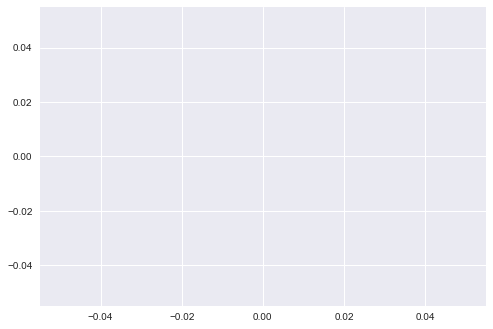

In [21]:
votes_donate = pd.read_csv(r'C:\Users\krred\Documents\Berkeley\w209\Final_Project\county_race_vote_donate.csv')
if 'party_binary' in votes_donate.columns:
    votes_donate.drop(['normalized_votes_interacted','party_binary','normalized_donate_interacted', 'Binarized Votes', 'Binarized Donations'],axis = 1, inplace = True)
votes_donate['normalized_donations'] = np.where(votes_donate['normalized_donations'].isna(),0,votes_donate['normalized_donations'])
votes_donate['party_binary'] = np.where(votes_donate['party'] == "DEM", 1, -1)
votes_donate['normalized_votes_interacted'] = votes_donate['party_binary'] * votes_donate['votes_winner'] * votes_donate['normalized_votes']
votes_donate['normalized_donate_interacted'] = votes_donate['party_binary'] * votes_donate['donation_winner'] * votes_donate['normalized_donations']
votes_donate['Binarized Votes'] = votes_donate['party_binary'] * votes_donate['votes']
votes_donate['Binarized Donations'] = votes_donate['party_binary'] * votes_donate['total_donations']

votes_donate.to_csv(r'C:\Users\krred\Documents\Berkeley\w209\Final_Project\county_race_vote_donate.csv')

sns.distplot(votes_donate['Binarized Donations'])

In [25]:
votes_donate[votes_donate['office'] == 'US President'].votes

2         29041
3         26471
6         93475
7        169799
10        62611
11        39333
14        18172
15         5936
19        72883
20        18458
25         5454
26         4871
31         6738
32         1874
38        22808
39         2150
44         1139
45         3530
50         4901
51         3726
56        32865
57        13242
62         7843
63         5784
69         8953
70         1547
75        15081
76         2911
80         4106
81         3109
          ...  
20968      9557
20973         0
20974      9745
20975      3603
20981         0
20982      2299
20983       296
20989         1
20990     76651
20991     46519
20997         0
20998      3850
20999       726
21008    160077
21009    243852
21018    148173
21019    240403
21026     53051
21027     39775
21036     38867
21037     38867
21038     45357
21049    159048
21050    205609
21055     54058
21056     62278
21061     34194
21062     38506
21067     25747
21068     21792
Name: votes, Length: 642

In [ ]:
votes_donate.office.value_counts()

In [ ]:
votes_donate[(votes_donate['office'] == "US President")& votes_donate['normalized_votes_interacted'] != 0].county_fips.nunique()

In [ ]:
votes_donate.sort_values(['county_fips','office']).head()